Project 4 - Advanced Lane Finding - Report. Vilas Chitrakaran. Feb 2017

## Executive Summary

__TODO__

## Camera Calibration

Corner detection failed on  ./camera_cal/calibration1.jpg
Corner detection failed on  ./camera_cal/calibration5.jpg
Corner detection failed on  ./camera_cal/calibration4.jpg
Camera intrinsic matrix:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion parameters:
 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
Test undistortion on one of the images


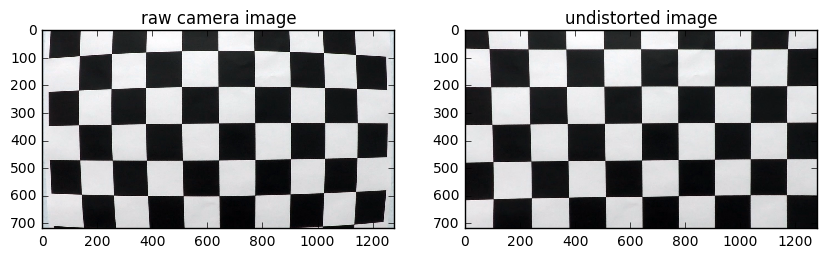

In [1]:
#=====================================================================
# Camera calibration
# Note: The following comes from code provided in examples directory

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt5
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), cv2.CALIB_CB_ADAPTIVE_THRESH)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.figure()
        cv2.imshow('img',img)
        cv2.waitKey(500)
    else:
        print("Corner detection failed on ", fname)

cv2.destroyAllWindows()

# now calibrate the camera
ret, cam_mtx, dist_pars, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera intrinsic matrix:\n', cam_mtx)
print('Camera distortion parameters:\n', dist_pars)

# test undistortion
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, cam_mtx, dist_pars, None, cam_mtx)

print('Test undistortion on one of the images')
f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(img)
axarr[0].set_title('raw camera image')
axarr[1].imshow(undist)
axarr[1].set_title('undistorted image');


## Setup Perspective Transform

* Find an image with straight road
* __undistort it__
* pick four points, transform to top view
    * use DVLA info on lane markings to determine correct ratios
* test on an image

Test perspective transform


array([[ -2.43055556e-01,  -1.47685185e+00,   7.93069444e+02],
       [ -1.90958360e-14,  -1.63194444e+00,   7.45833333e+02],
       [ -3.25260652e-17,  -2.31481481e-03,   1.00000000e+00]])

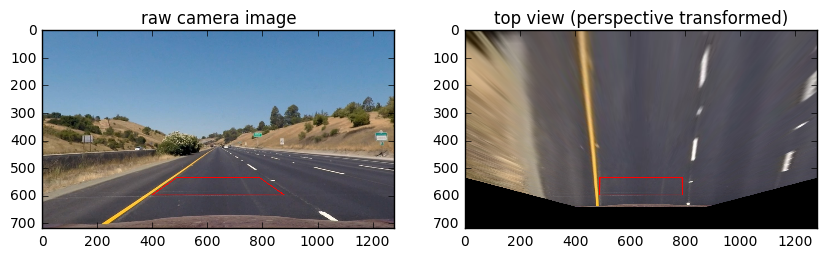

In [9]:
#=====================================================================
# Setup perspective transform

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

# generate perspective transform from src points defined as a trapeziod to
# dst defined as a rectangle
# xcenter - x-coord of vertical centerline through the road
# xoffsettop - x offset of left and right edges of the road at the top
# xoffsetbottom - x offset of left and right edges of the road at the bottom
# ytop - y-coord of the top of the road
# ybottom - y-coord of the bottom of the road
def setup_perspective(xcenter, xoffsettop, xoffsetbottom, ytop, ybottom):
    
    # These points were selected from test_images/straight_lines1.jpg after applying undistortion
    src = np.float32(
        [[xcenter+xoffsettop,ytop],
         [xcenter+xoffsetbottom,ybottom],
         [xcenter-xoffsetbottom,ybottom],
         [xcenter-xoffsettop,ytop]])

    dst = np.float32(
        [[xcenter+xoffsetbottom,ytop],
         [xcenter+xoffsetbottom,ybottom],
         [xcenter-xoffsetbottom,ybottom],
         [xcenter-xoffsetbottom,ytop]])

    mtx = cv2.getPerspectiveTransform(src, dst)
    return src, dst, mtx

# undistort the image and apply perspective transform to generate top view
def generate_top_view(image, cam_mtx, dist_pars, pers_mtx):
    undist = cv2.undistort(image, cam_mtx, dist_pars, None, cam_mtx)
    img_size = (image.shape[1], image.shape[0])
    transformed = cv2.warpPerspective(undist, pers_mtx, img_size, flags=cv2.INTER_LINEAR)
    return transformed

def generate_perspective_params(xcenter, xoffsettop, xoffsetbottom, ytop, ybottom):
    imsrc, imdst, pers_mtx = setup_perspective(xcenter, xoffsettop, xoffsetbottom, ytop, ybottom)
    image = cv2.imread('./test_images/straight_lines1.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image, cam_mtx, dist_pars, None, cam_mtx)
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.polylines(undist, np.int32([imsrc]), True, (255,0,0), 2)
    transformed = cv2.warpPerspective(undist, pers_mtx, img_size, flags=cv2.INTER_LINEAR)

    
    print('Test perspective transform')
    f, axarr = plt.subplots(1,2,figsize=(10,10))
    axarr[0].imshow(undist)
    axarr[0].set_title('undistorted camera image')
    axarr[1].imshow(transformed)
    axarr[1].set_title('top view (perspective transformed)');
    return pers_mtx

pers_mtx = interact(generate_perspective_params, 
                    xcenter=(100,700), 
                    xoffsettop=(100,700),
                    xoffsetbottom=(0,600), 
                    ytop=(600,1200), 
                    ybottom=(0,600))
